# Comparing axis-aligned decision tree versus oblique decision tree on simulation datasets
The previous notebook conducted visual analysis using `Iris` dataset. Here we extend our analysis using `2` more custom simulation datasets: `sparse_parity`, `trunk` along with other simulation datasets from scikit-learn datasets module

## Environment
- Python 3.8.13
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquepr)

In [1]:
!python --version

Python 3.8.13


## Import packages

In [2]:
import sklearn
from sklearn.tree import DecisionTreeClassifier, ObliqueDecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_low_rank_matrix, make_multilabel_classification, \
                            make_circles, make_moons, make_hastie_10_2, make_blobs, \
                            make_sparse_uncorrelated, make_gaussian_quantiles
from sklearn.model_selection import RepeatedKFold, cross_validate

from datetime import datetime
from tqdm import tqdm
import itertools
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 123456

sklearn.__version__

'1.2.dev0'

In [3]:
today = str(datetime.now().date())
today

'2022-05-29'

#### Generating custom simulation datasets

In [4]:
def sparse_parity(n_samples, p=20, p_star=3, noise=None, random_seed=None, **kwarg):
 
    if random_seed: 
        np.random.seed(random_seed)

    X = np.random.uniform(-1, 1, (n_samples, p))
    y = np.zeros(n_samples)

    for i in range(0, n_samples):
        y[i] = sum(X[i, :p_star] > 0) % 2;

    return X, y

def trunk(n_samples, p=10, noise=None, random_seed=None, **kwarg):

    if random_seed: 
        np.random.seed(random_seed)

    mu_1 = np.array([1/i for i in range(1,p+1)])
    mu_0 = -1 * mu_1

    cov = np.identity(p)

    X = np.vstack((
        np.random.multivariate_normal(mu_0, cov, int(n_samples/2)),
        np.random.multivariate_normal(mu_1, cov, int(n_samples/2))
        ))

    y = np.concatenate((
        np.zeros(int(n_samples/2)),
        np.ones(int(n_samples/2))
        ))

    return X, y

In [5]:
def get_sample(func, n, m=None, o=None):
    k = {}

    if m: k['noise'] = m
    if o: k['n_features'] = o

    k['n_samples'] = n
    k['random_state'] = random_state # random_state for classifiers

    X, y = func(**k)

    return X, y

def get_scores(X, y, max_features, max_depth, random_state, n_cv=5, n_repeats=10):

    clfs = [
        RandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state),
        ObliqueRandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state)
    ]

    tmp = []

    for i, clf in enumerate(clfs):

        if i == 0 and isinstance(max_features, int):
            if max_features > X.shape[1]:
                tmp.append(np.zeros(n_cv * n_repeats))
                continue

        cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
        test_score = cross_validate(estimator=clf, X=X, y=y, cv=cv, scoring='accuracy')
        
        tmp.append(
            test_score['test_score']
        )

    # print(f'max_feature: {max_features} | max_depth: {max_depth}')

    return tmp

In [6]:
def run_experiment(n_repeat=10):
    n_samples = [100, 1000, 5000]
    max_depths = [1,2,5,10, None]
    accs = []
    
    clf_kwarg = {
        'max_features': None,
        'max_depth': None,
        'random_state': random_state
    }

    for n_sample in tqdm(n_samples):
        data_args = [
            # name of dataset, function, n_sample, noise, n_features
            ['sparse_parity', sparse_parity, n_sample],
            ['trunk', trunk, n_sample],
            ['make_gaussian_quantiles', make_gaussian_quantiles, n_sample, None, 10], #noise, n_features
            ['make_circles', make_circles, n_sample, 0.3], #noise
            ['make_moons', make_moons, n_sample, 0.4],
            ['make_hastie_10_2', make_hastie_10_2, n_sample]
        ]

        for arg in data_args:

            X, y = get_sample(*arg[1:])
            
            for max_feature in ['sqrt', X.shape[1], X.shape[1]*2, X.shape[1]*3]: #max_features
                for max_depth in max_depths:
                    clf_kwarg['max_features'] = max_feature
                    clf_kwarg['max_depth'] = max_depth

                    acc = get_scores(X, y, **clf_kwarg)
                    accs.append([arg[0], n_sample, n_repeat, max_feature, max_depth, random_state] + acc)

    df = pd.DataFrame(accs, columns=['dataset', 'n_sample', 'n_repeat', 'max_feature', 'max_depth', 'random_state', 'RF', 'OF'])
    df['delta'] = df.apply(lambda x: x.OF-x.RF, axis=1)

    with open('dat/simulation_notebook_rf_vs_of.pkl', 'wb') as f:
        pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

    return df

In [7]:
df = run_experiment()

100%|██████████| 3/3 [3:06:56<00:00, 3738.92s/it]


In [8]:
df

,dataset,n_sample,n_repeat,max_feature,max_depth,random_state,RF,OF,delta
0,sparse_parity,100,10,sqrt,1.0,123456,"[0.4, 0.35, 0.45, 0.6, 0.5, 0.6, 0.6, 0.5, 0.3...","[0.55, 0.4, 0.45, 0.3, 0.4, 0.65, 0.55, 0.4, 0...","[0.15000000000000002, 0.050000000000000044, 0...."
1,sparse_parity,100,10,sqrt,2.0,123456,"[0.4, 0.4, 0.5, 0.55, 0.4, 0.5, 0.6, 0.45, 0.3...","[0.4, 0.4, 0.4, 0.5, 0.35, 0.4, 0.5, 0.5, 0.35...","[0.0, 0.0, -0.09999999999999998, -0.0500000000..."
2,sparse_parity,100,10,sqrt,5.0,123456,"[0.35, 0.55, 0.5, 0.6, 0.5, 0.55, 0.5, 0.5, 0....","[0.55, 0.4, 0.5, 0.5, 0.5, 0.55, 0.4, 0.6, 0.4...","[0.20000000000000007, -0.15000000000000002, 0...."
3,sparse_parity,100,10,sqrt,10.0,123456,"[0.5, 0.5, 0.4, 0.6, 0.5, 0.5, 0.55, 0.5, 0.55...","[0.4, 0.45, 0.4, 0.55, 0.35, 0.6, 0.55, 0.5, 0...","[-0.09999999999999998, -0.04999999999999999, 0..."
4,sparse_parity,100,10,sqrt,NaN,123456,"[0.5, 0.5, 0.4, 0.6, 0.5, 0.5, 0.55, 0.5, 0.55...","[0.45, 0.45, 0.45, 0.55, 0.35, 0.6, 0.55, 0.5,...","[-0.04999999999999999, -0.04999999999999999, 0..."
...,...,...,...,...,...,...,...,...,...
355,make_hastie_10_2,5000,10,30,1.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.712, 0.729, 0.744, 0.73, 0.668, 0.75, 0.727...","[0.712, 0.729, 0.744, 0.73, 0.668, 0.75, 0.727..."
356,make_hastie_10_2,5000,10,30,2.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.756, 0.759, 0.791, 0.778, 0.697, 0.776, 0.7...","[0.756, 0.759, 0.791, 0.778, 0.697, 0.776, 0.7..."
357,make_hastie_10_2,5000,10,30,5.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.817, 0.815, 0.859, 0.851, 0.814, 0.846, 0.8...","[0.817, 0.815, 0.859, 0.851, 0.814, 0.846, 0.8..."
358,make_hastie_10_2,5000,10,30,10.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.876, 0.88, 0.88, 0.882, 0.885, 0.889, 0.873...","[0.876, 0.88, 0.88, 0.882, 0.885, 0.889, 0.873..."


In [9]:
df2 = df.copy()
df2['max_depth'] = df2.max_depth.replace(np.nan, 'inf')

In [10]:
df2

,dataset,n_sample,n_repeat,max_feature,max_depth,random_state,RF,OF,delta
0,sparse_parity,100,10,sqrt,1.0,123456,"[0.4, 0.35, 0.45, 0.6, 0.5, 0.6, 0.6, 0.5, 0.3...","[0.55, 0.4, 0.45, 0.3, 0.4, 0.65, 0.55, 0.4, 0...","[0.15000000000000002, 0.050000000000000044, 0...."
1,sparse_parity,100,10,sqrt,2.0,123456,"[0.4, 0.4, 0.5, 0.55, 0.4, 0.5, 0.6, 0.45, 0.3...","[0.4, 0.4, 0.4, 0.5, 0.35, 0.4, 0.5, 0.5, 0.35...","[0.0, 0.0, -0.09999999999999998, -0.0500000000..."
2,sparse_parity,100,10,sqrt,5.0,123456,"[0.35, 0.55, 0.5, 0.6, 0.5, 0.55, 0.5, 0.5, 0....","[0.55, 0.4, 0.5, 0.5, 0.5, 0.55, 0.4, 0.6, 0.4...","[0.20000000000000007, -0.15000000000000002, 0...."
3,sparse_parity,100,10,sqrt,10.0,123456,"[0.5, 0.5, 0.4, 0.6, 0.5, 0.5, 0.55, 0.5, 0.55...","[0.4, 0.45, 0.4, 0.55, 0.35, 0.6, 0.55, 0.5, 0...","[-0.09999999999999998, -0.04999999999999999, 0..."
4,sparse_parity,100,10,sqrt,inf,123456,"[0.5, 0.5, 0.4, 0.6, 0.5, 0.5, 0.55, 0.5, 0.55...","[0.45, 0.45, 0.45, 0.55, 0.35, 0.6, 0.55, 0.5,...","[-0.04999999999999999, -0.04999999999999999, 0..."
...,...,...,...,...,...,...,...,...,...
355,make_hastie_10_2,5000,10,30,1.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.712, 0.729, 0.744, 0.73, 0.668, 0.75, 0.727...","[0.712, 0.729, 0.744, 0.73, 0.668, 0.75, 0.727..."
356,make_hastie_10_2,5000,10,30,2.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.756, 0.759, 0.791, 0.778, 0.697, 0.776, 0.7...","[0.756, 0.759, 0.791, 0.778, 0.697, 0.776, 0.7..."
357,make_hastie_10_2,5000,10,30,5.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.817, 0.815, 0.859, 0.851, 0.814, 0.846, 0.8...","[0.817, 0.815, 0.859, 0.851, 0.814, 0.846, 0.8..."
358,make_hastie_10_2,5000,10,30,10.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.876, 0.88, 0.88, 0.882, 0.885, 0.889, 0.873...","[0.876, 0.88, 0.88, 0.882, 0.885, 0.889, 0.873..."


In [11]:
df2.explode(['RF','OF']).groupby(['dataset', 'n_sample' ,'max_feature', 'max_depth'])[['RF', 'OF']].mean()

RF       OF
dataset      n_sample max_feature max_depth                  
make_circles 100      2           1.0        0.53200  0.53100
                                  2.0        0.56200  0.55900
                                  5.0        0.58300  0.59100
                                  10.0       0.57200  0.55400
                                  inf        0.57100  0.55400
...                                              ...      ...
trunk        5000     sqrt        1.0        0.86152  0.86972
                                  2.0        0.87084  0.88086
                                  5.0        0.88590  0.89040
                                  10.0       0.89072  0.89312
                                  inf        0.89076  0.89346

[360 rows x 2 columns]

In [12]:
df3 = df2.explode(['RF','OF'])[['dataset', 'n_sample', 'max_feature', 'max_depth', 'RF','OF']]
df3

,dataset,n_sample,max_feature,max_depth,RF,OF
0,sparse_parity,100,sqrt,1.0,0.4,0.55
0,sparse_parity,100,sqrt,1.0,0.35,0.4
0,sparse_parity,100,sqrt,1.0,0.45,0.45
0,sparse_parity,100,sqrt,1.0,0.6,0.3
0,sparse_parity,100,sqrt,1.0,0.5,0.4
...,...,...,...,...,...,...
359,make_hastie_10_2,5000,30,inf,0.0,0.912
359,make_hastie_10_2,5000,30,inf,0.0,0.908
359,make_hastie_10_2,5000,30,inf,0.0,0.896
359,make_hastie_10_2,5000,30,inf,0.0,0.899


In [13]:
df3.dataset.unique()

array(['sparse_parity', 'trunk', 'make_gaussian_quantiles',
       'make_circles', 'make_moons', 'make_hastie_10_2'], dtype=object)

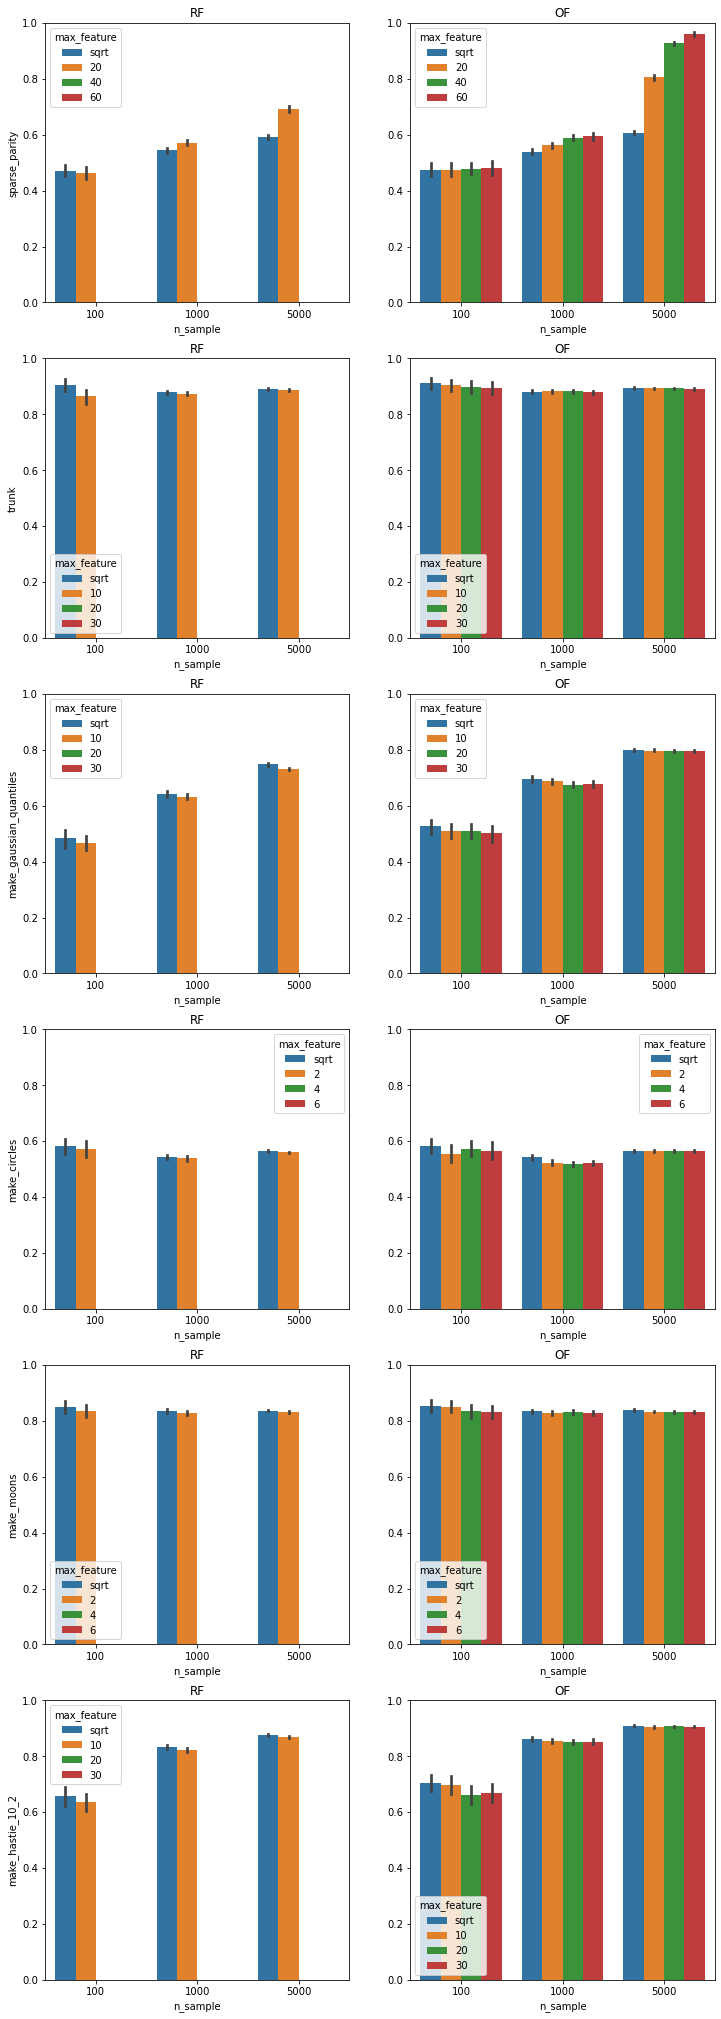

In [20]:
dset = df3.dataset.unique()

fig, ax = plt.subplots(dset.shape[0], 2, figsize=(12,6*dset.shape[0]))

for i, d in enumerate(dset):

    df_new = df3.query(f'dataset == "{d}" and max_depth == "inf"')

    sns.barplot(data=df_new, x='n_sample', y='RF', hue='max_feature', ax=ax[i,0])
    sns.barplot(data=df_new, x='n_sample', y='OF', hue='max_feature', ax=ax[i,1])

    m = 1.0#round(max(df_new.RF.max(), df_new.OF.max()))

    ax[i,0].set_ylim(0, m)
    ax[i,1].set_ylim(0, m)
    ax[i,0].set_title('RF')
    ax[i,1].set_title('OF')
    ax[i,0].set_ylabel(f'{d}')
    ax[i,1].set_ylabel('')

In [21]:
q1 = f'dataset == "{d}" and max_depth == "inf"'
q2 = f'max_feature == 1'
# q4 = f'max_feature != 1'

df_new = df3.query(q1)

In [36]:
df_new[~(df_new.max_feature == 'sqrt')].max_feature.min()

10

In [37]:
dset = df3.dataset.unique()
df33 = df3.copy()

for i, d in enumerate(dset):

    q1 = f'dataset == "{d}" and max_depth == "inf"'

    df_new = df3.query(q1)
    n_feature = df_new[~(df_new.max_feature == 'sqrt')].max_feature.min() #minimum numeric max_feature

    df_mf1 = df_new.query(f'max_feature == {n_feature}') #RF max_feature to be compared with OF 2x, 3x max_feature

    for ns in df_mf1.n_sample.unique(): #n_sample
        for mf_not_1 in df_new.max_feature.unique():
            q3 = f'n_sample == {ns}'
            
            if mf_not_1 in [n_feature, 'sqrt']:
                continue

            indexing = (df33.dataset==d) & (df33.max_depth=='inf') & (df33.n_sample==ns) & (df33.max_feature==mf_not_1)
            df33.loc[indexing, ['RF']] = df_mf1.query(q3).RF.tolist()

df33['delta'] = df33.apply(lambda x: x.OF-x.RF, axis=1)

In [38]:
df33

,dataset,n_sample,max_feature,max_depth,RF,OF,delta
0,sparse_parity,100,sqrt,1.0,0.4,0.55,0.150
0,sparse_parity,100,sqrt,1.0,0.35,0.4,0.050
0,sparse_parity,100,sqrt,1.0,0.45,0.45,0.000
0,sparse_parity,100,sqrt,1.0,0.6,0.3,-0.300
0,sparse_parity,100,sqrt,1.0,0.5,0.4,-0.100
...,...,...,...,...,...,...,...
359,make_hastie_10_2,5000,30,inf,0.876,0.912,0.036
359,make_hastie_10_2,5000,30,inf,0.873,0.908,0.035
359,make_hastie_10_2,5000,30,inf,0.861,0.896,0.035
359,make_hastie_10_2,5000,30,inf,0.854,0.899,0.045


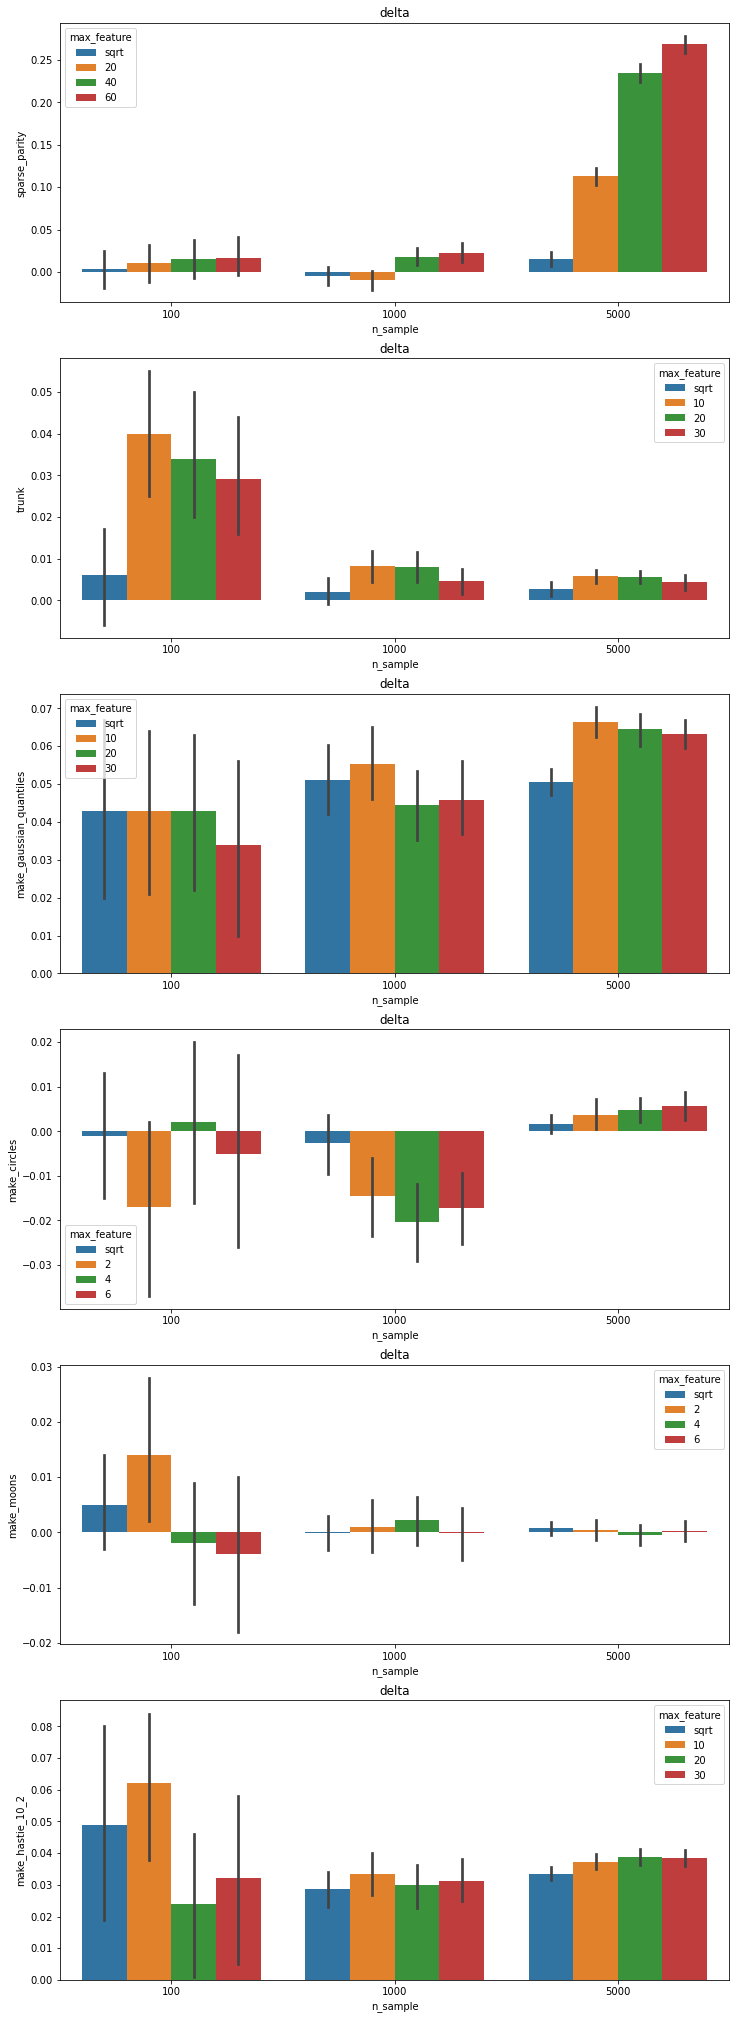

In [39]:
dset = df33.dataset.unique()

fig, ax = plt.subplots(dset.shape[0], 1, figsize=(12,6*dset.shape[0]))

for i, d in enumerate(dset):

    df_new = df33.query(f'dataset == "{d}" and max_depth == "inf"')

    sns.barplot(data=df_new, x='n_sample', y='delta', hue='max_feature', ax=ax[i])

    ax[i].set_title('delta')
    ax[i].set_ylabel(f'{d}')

## Appendix

In [18]:
dff2 = df2.explode(['RF', 'OF'])[['dataset', 'n_sample', 'max_feature', 'max_depth', 'RF', 'OF']].groupby(['dataset', 'n_sample', 'max_feature','max_depth']).mean()
dff2.style.background_gradient(cmap='RdBu_r', low=0, high=0, vmin=0, vmax=1)